In [2]:
import numpy as np
import matplotlib.pyplot as plt
import NSsolver as ns
from scipy import optimize, linalg
try:
    plt.style.use("jupyter")
except OSError:
    print("Delaut syle in use")

In [42]:
class BGrid(object):
    def __init__(self, n, dx=[1,1]):
        
        # grid size
        self.nx,self.ny = n
        self.dx,self.dy = dx
        self.dx2 = self.dx/2.
        self.dy2 = self.dy/2.
        
        # cell center location, zero-centered
        self.x = np.arange(-self.nx//2,self.nx//2)+self.dx2
        self.y = np.arange(-self.ny//2,self.ny//2)+self.dy2
        
        self.xmin=min(self.x); self.xmax=max(self.x)
        self.ymin=min(self.y); self.ymax=max(self.y)
        
        self.U = np.ones((self.ny,self.nx,2))
        
    def avrgCell(self, S):
        for i in range(1,self.nx-1):
            for j in range(1,self.ny-1):
                # cell center location
                x=grid.x[i]; y=grid.y[j]
                idx = np.where((S[:,:,0]>=x-grid.dx)&(S[:,:,0]<x+grid.dx)&
                               (S[:,:,1]>=y-grid.dy)&(S[:,:,1]<y+grid.dx),1,0)!=0
                self.U[j,i,0] = np.average(S[idx,2])
                self.U[j,i,1] = np.average(S[idx,3])
        self.applyBC()
        
    def applyBC(self):
        # top and bottom
        self.U[0,:,:] = self.U[-2,:,:]
        self.U[-1,:,:] = self.U[1,:,:]
        # inlet
        self.U[:,0,0]=1.
        self.U[:,0,1]=0.
        #outlet
        self.U[:,-1,:] = self.U[:,-2,:] 
        
    def show(self):
        plt.hlines(self.y+self.dy2,self.xmin-self.dx2,self.xmax+self.dx2)
        plt.hlines(self.y-self.dy2,self.xmin-self.dx2,self.xmax+self.dx2)
        plt.vlines(self.x-self.dx2,self.ymin-self.dy2,self.ymax+self.dy2)
        plt.vlines(self.x+self.dx2,self.ymin-self.dy2,self.ymax+self.dx2)
        plt.plot(self.x+0.*self.y[:,np.newaxis], self.y, '.r')
    def showU(self):
        self.show()
        X, Y = np.meshgrid(self.x, self.y)
        plt.quiver(X, Y, self.U[:,:,0],self.U[:,:,1])

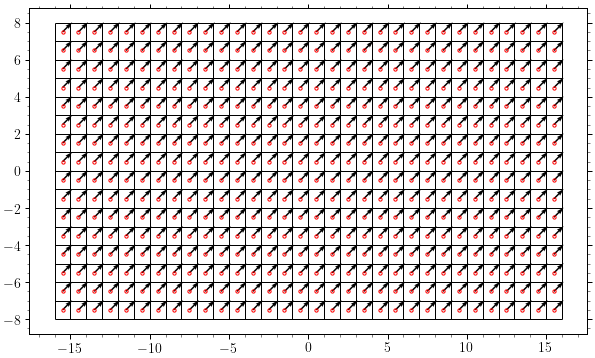

In [4]:
grid = BGrid(n=(32,16))
grid.show()
grid.showU()

In [6]:
def seed(grid, n=4):
    nx,ny = grid.nx,grid.ny
    S = np.random.rand(nx*n,ny*n,4)
    # seed only interior points
    S[:,:,0] = S[:,:,0]*2*(grid.xmax-grid.dx2)+grid.xmin+grid.dx2
    S[:,:,1] = S[:,:,1]*2*(grid.ymax-grid.dy2)+grid.ymin+grid.dy2
    # velocities
    S[:,:,2] = 1
    S[:,:,3] = 0.
    return S

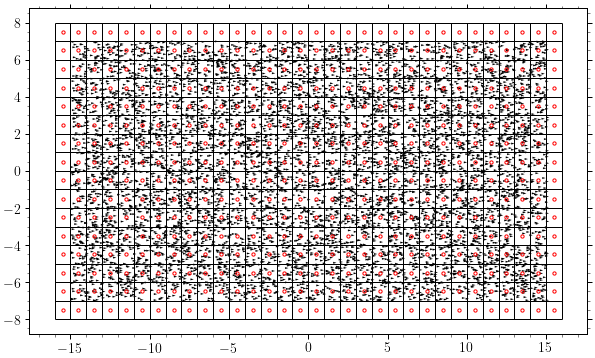

In [7]:
S = seed(grid)
plt.quiver(S[:,:,0],S[:,:,1],S[:,:,2],S[:,:,3])
grid.show();

In [8]:
def applyBC(S, grid):
    # x-direction BC
    S[:,:,0] = np.where(S[:,:,0]>grid.xmax-grid.dx2,S[:,:,0]-grid.xmax+grid.xmin+grid.dx,S[:,:,0])
    S[:,:,0] = np.where(S[:,:,0]<grid.xmin+grid.dx2,S[:,:,0]+grid.xmax-grid.xmin-grid.dx,S[:,:,0])
    # y-direction BC
    S[:,:,1] = np.where(S[:,:,1]>grid.ymax-grid.dy2,S[:,:,1]-grid.ymax+grid.ymin+grid.dy,S[:,:,1])
    S[:,:,1] = np.where(S[:,:,1]<grid.ymin+grid.dy2,S[:,:,1]+grid.ymax-grid.ymin-grid.dy,S[:,:,1])
    return S

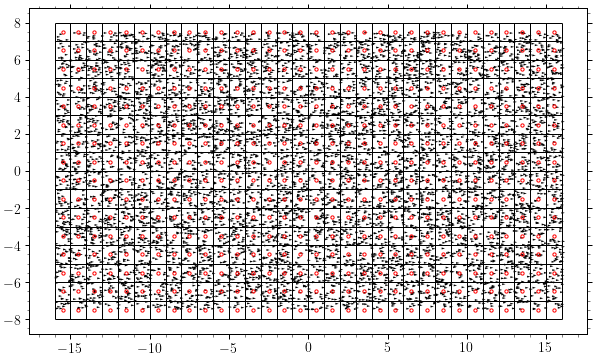

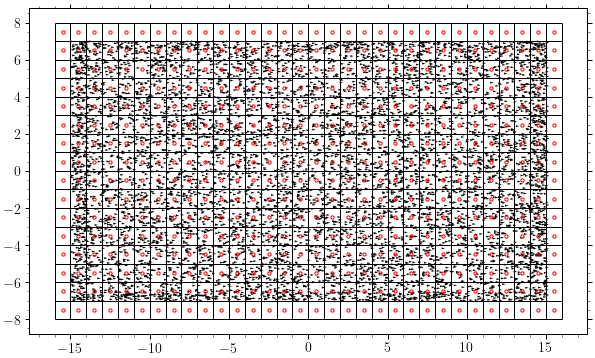

In [9]:
# move to right and up
S = seed(grid)
S[:,:,:2] *= 16./15.
plt.quiver(S[:,:,0],S[:,:,1],S[:,:,2],S[:,:,3])
grid.show()
plt.show();
# should move "back"
S = applyBC(S, grid)
plt.quiver(S[:,:,0],S[:,:,1],S[:,:,2],S[:,:,3])
grid.show()
plt.show();

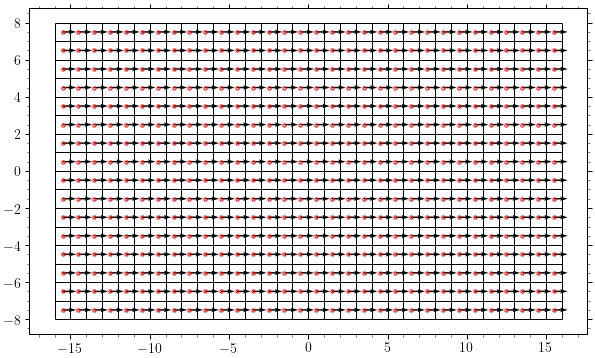

In [10]:
S = seed(grid)
grid.avrgCell(S)
# plt.quiver(S[:,:,0],S[:,:,1],S[:,:,2],S[:,:,3])
grid.showU()
grid.show()

In [15]:
def advectSeed(grid, S, dt=1):
    # interpolate seed velocity from neighbouring cells
    nx,ny,_=S.shape
    for i in range(nx):
        for j in range(ny):
            u, v = interp(grid, S[i,j,:2])
            S[i,j,0] += dt*u
            S[i,j,1] += dt*v
    return S

In [34]:
def interp(grid, Sx):
    disx = grid.x-Sx[0]
    disy = grid.y[:,np.newaxis]-Sx[1]
    u = np.sum(grid.U[:,:,0]*kernel(disx)*kernel(disy))
    v = np.sum(grid.U[:,:,1]*kernel(disx)*kernel(disy))
    return u, v
def kernel(d, a=4):
    kern = np.where(abs(d)<a,np.sinc(d)*np.sinc(d/a),0)
    return kern

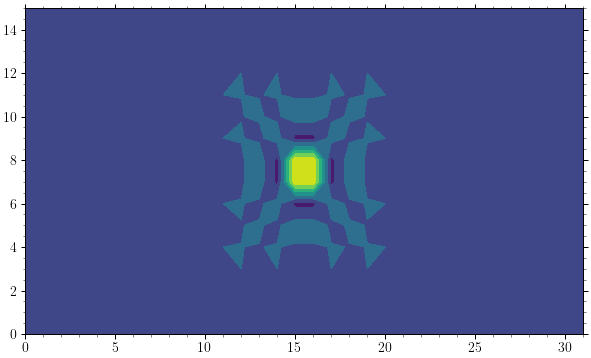

In [35]:
plt.contourf(kernel(grid.x-0)*kernel(grid.y-0)[:,np.newaxis]);

In [36]:
# should recover [1, 1]
np.round(interp(grid, [0,0]), 6)

array([1.004871, 0.      ])

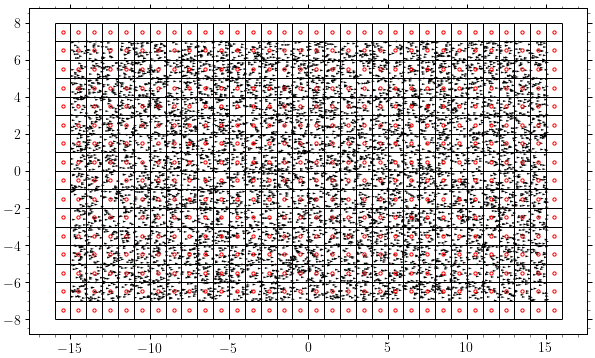

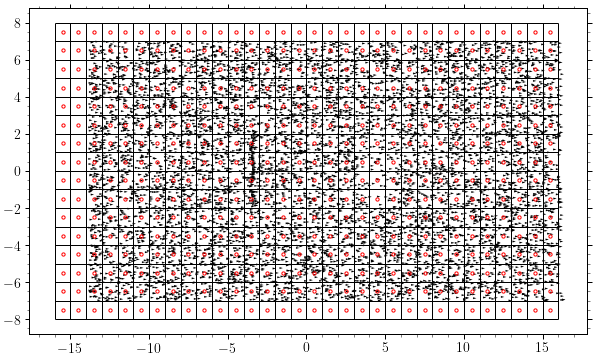

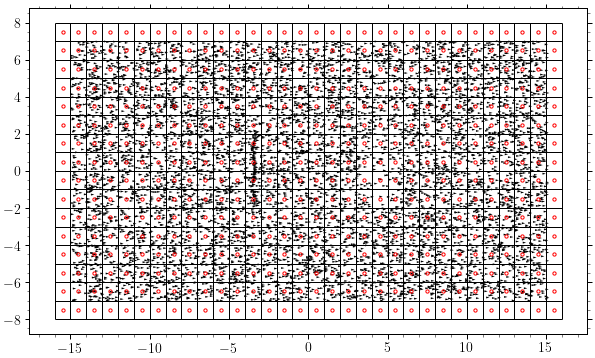

In [40]:
S = seed(grid)
plt.quiver(S[:,:,0],S[:,:,1],S[:,:,2],S[:,:,3])
grid.show(); plt.show();
grid.U[6:10,12:20,:] = 0.
S = advectSeed(grid, S)
plt.quiver(S[:,:,0],S[:,:,1],S[:,:,2],S[:,:,3])
grid.show(); plt.show();
S = applyBC(S, grid)
plt.quiver(S[:,:,0],S[:,:,1],S[:,:,2],S[:,:,3])
grid.show(); plt.show();

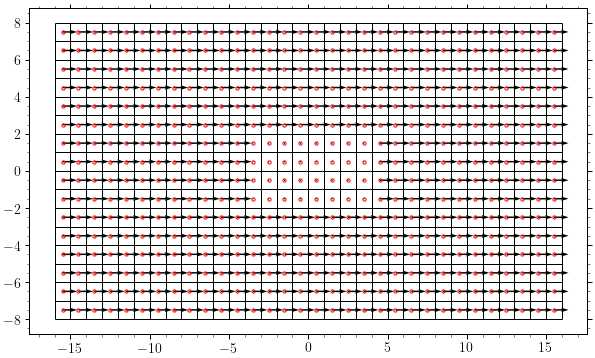

In [44]:
grid.showU()
grid.show()

In [72]:
class nodes(object):
    def __init__(self, omega, solid=False):
        self.densities = np.zeros(9)
        self.solid = solid
        self.omega = omega

In [73]:
Lattice = np.empty((8, 8), dtype=object)

In [74]:
Lattice[:,:] = nodes(omega=1)

In [75]:
Lattice[:,0]

array([<__main__.nodes object at 0x11a41d470>,
       <__main__.nodes object at 0x11a41d470>], dtype=object)

In [76]:
def Gaussian(t, sigma, t0=0):
    return (2*np.pi*sigma)**(-0.5)*np.exp(-0.5*((t-t0)/sigma)**2)

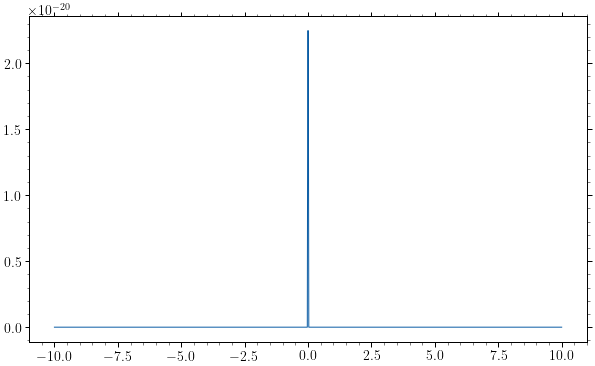

In [79]:
t = np.linspace(-10,10,1024)
plt.plot(t, Gaussian(t, 0.001));